# Outline

Here we will train a fully-connected network to classify hand-written digits from images using the MNIST dataset

The network will take 28x28 pixel images and map them to digit categories {0, 1, 2, ..., 9}. 

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this.  

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)


# Display some images

In [3]:
%run plot_conf.py

In [4]:
plt_style()

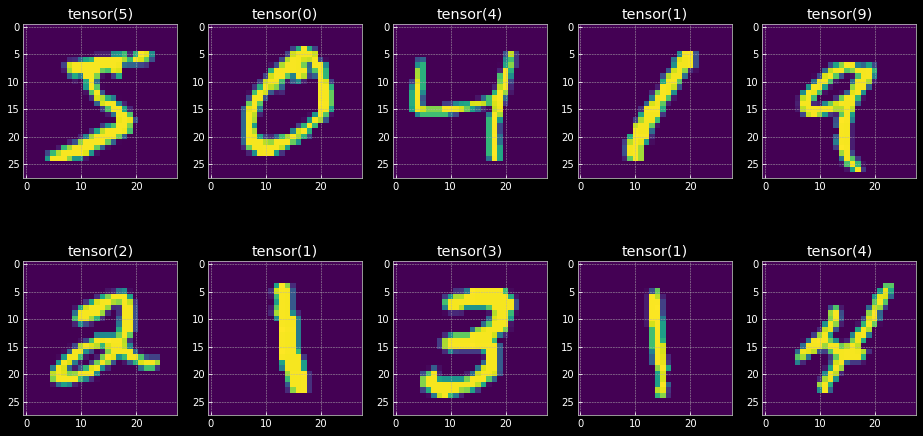

In [5]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.title(label)

# Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model class (1 Layer Network)

In [7]:
class Network1Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(Network1Layer, self).__init__()
        self.input_size = input_size
        self.layer1 = nn.Linear(input_size, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return F.log_softmax(x, dim=1)


# Define Training Loop

* Loop batches of samples in the training set
* Run each batch through the model (forward pass)
* Compute the loss
* Compute the gradients with respect to model parameters (backward pass)
* Update the parameters

In [11]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) #convert to CUDA tensors
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item()))

# Define Testing Loop

* Loop over batches of samples in the testing set
* Run each batch through the model (forward pass)
* Compute the loss and accuracy
* Do not compute gradients or update model parameters 
* We are saving the testing data to evaluate how the model is doing on data it has not been trained on

In [12]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device) #convert to CUDA tensors
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))

# Initialize the Model and Optimizer

In [13]:
# Training settings 
input_size  = 28*28   # images are 28x28 pixels
n_hidden    = 100     # number of hidden units
output_size = 10      # there are 10 classes

model = Network1Layer(input_size, n_hidden, output_size)
model.to(device) #convert to CUDA model
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Train the Model

* We will only train for a few epochs here
* Normally we would train for longer
* Depending on the dataset and model size, this can take days or weeks

In [14]:
for epoch in range(1, 3):
    train(epoch)
    test()

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.322414
Train Epoch: 3 [6400/60000 (11%)]	Loss: 1.331511
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.551818
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.588376
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.384392
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.255093
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.418124
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.449223
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.206022
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.254138

Test set: Average loss: 0.2691, Accuracy: 9226/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.271154
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.277687
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.363163
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.255735
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.402942
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.391969
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.261624
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.199158
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.149243
T

# Now show some model predictions on testing data

* We will show an image from the testing set, and the probabilities the model assigns to each class

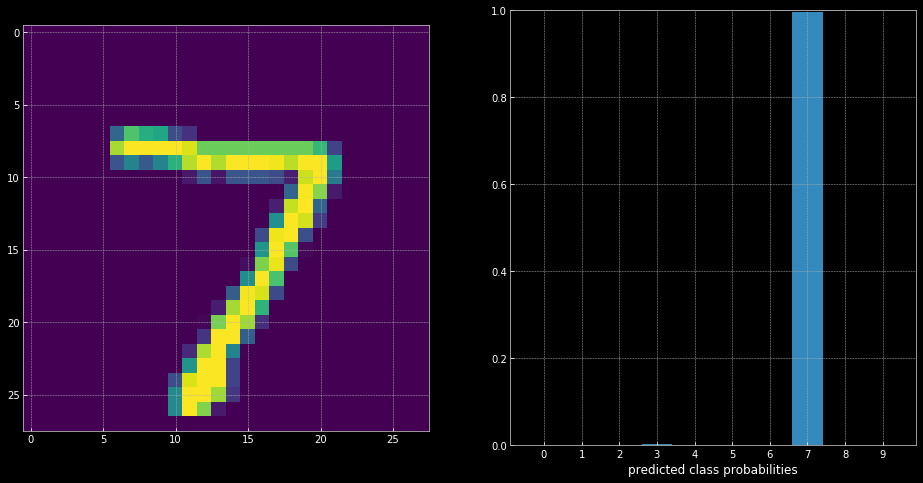

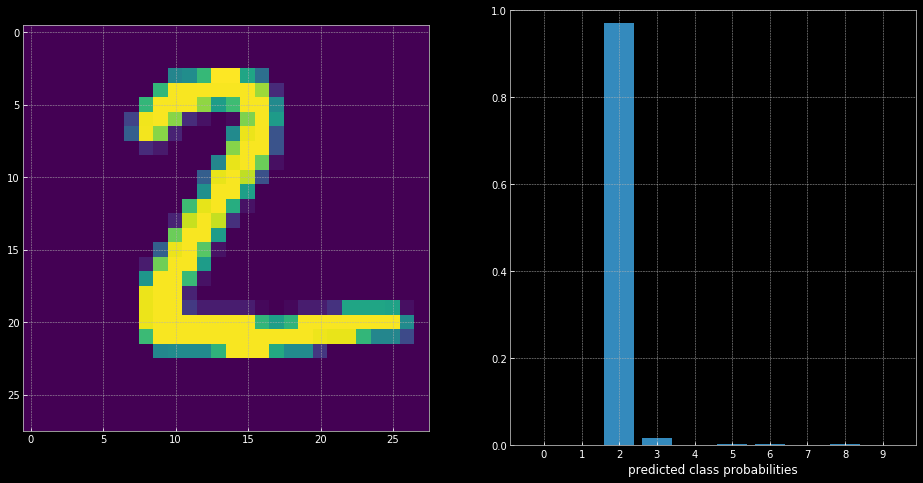

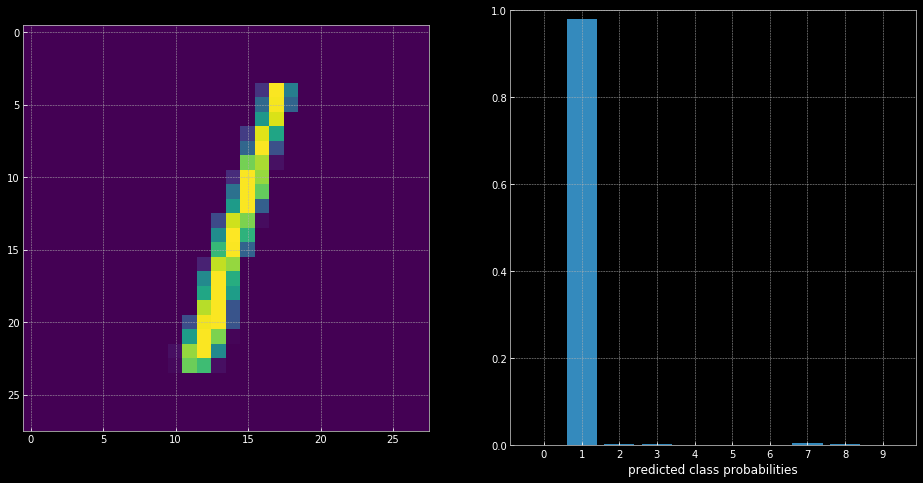

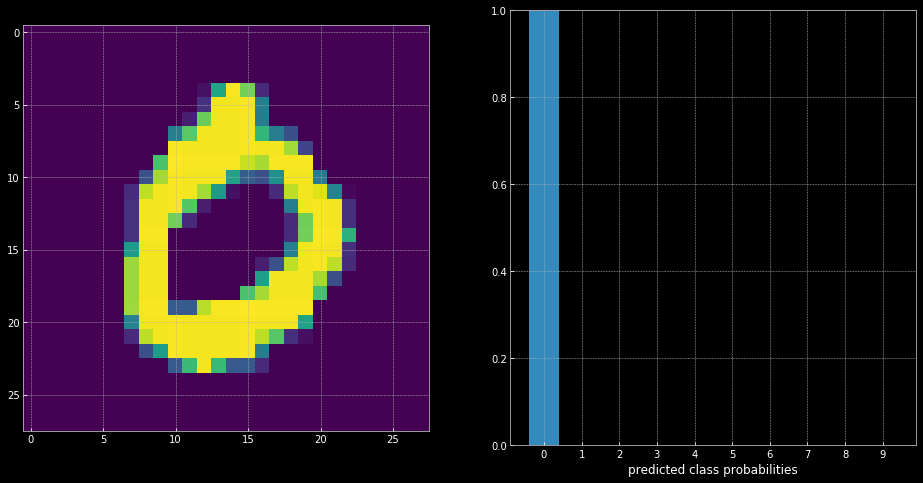

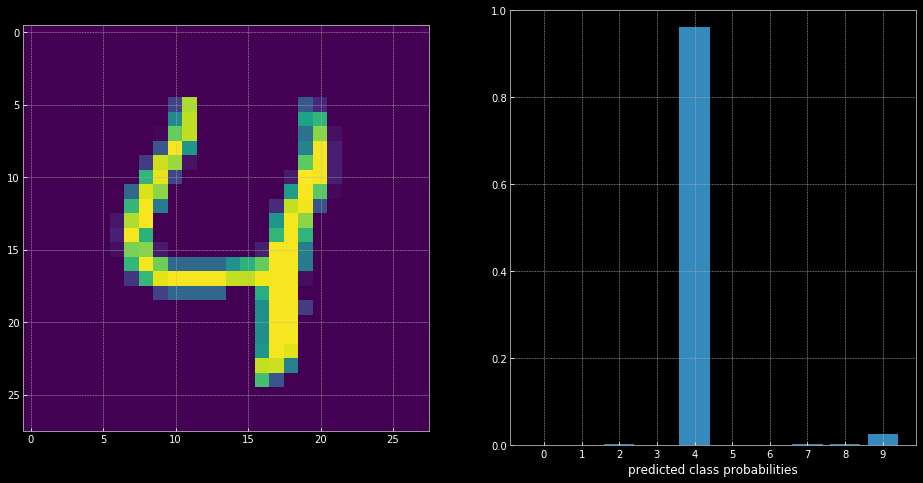

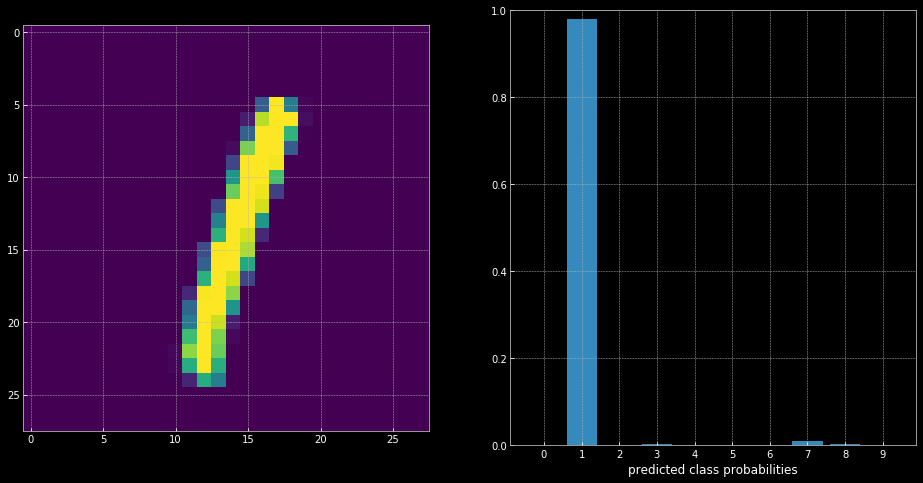

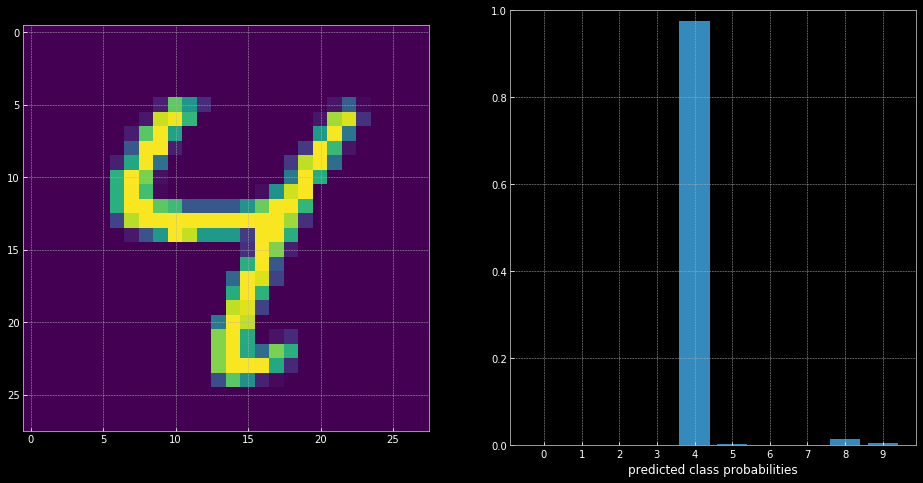

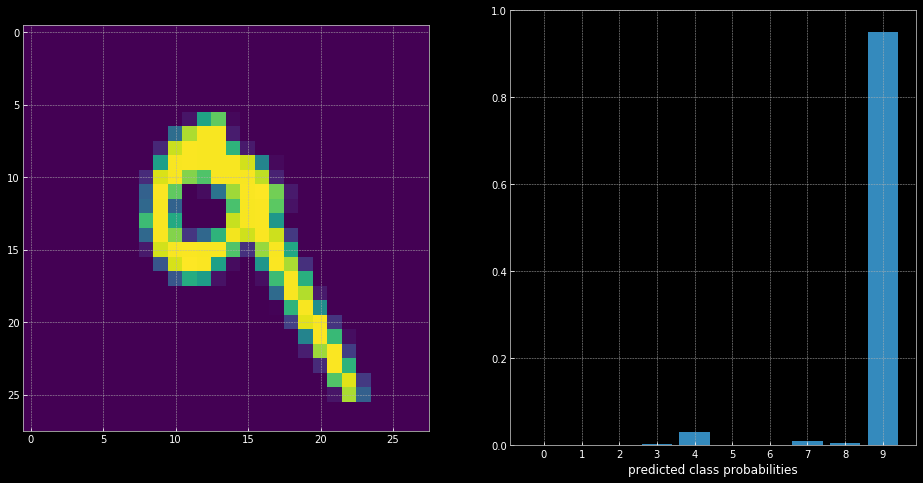

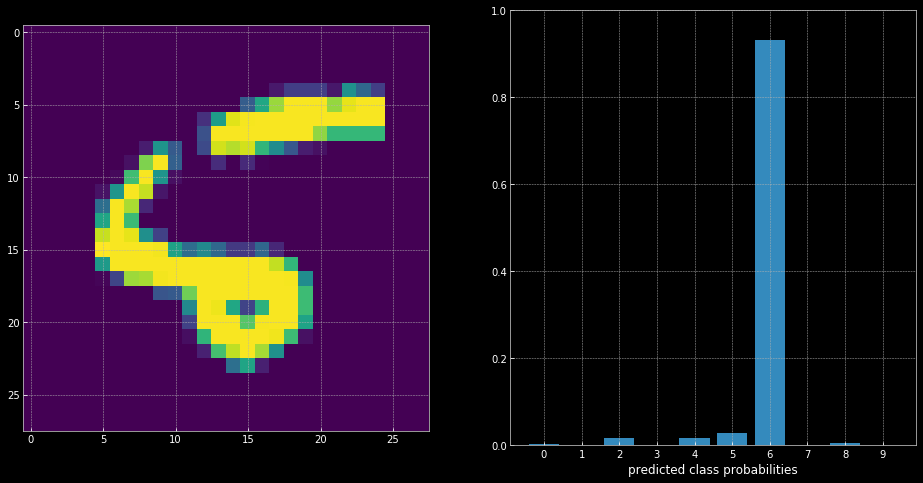

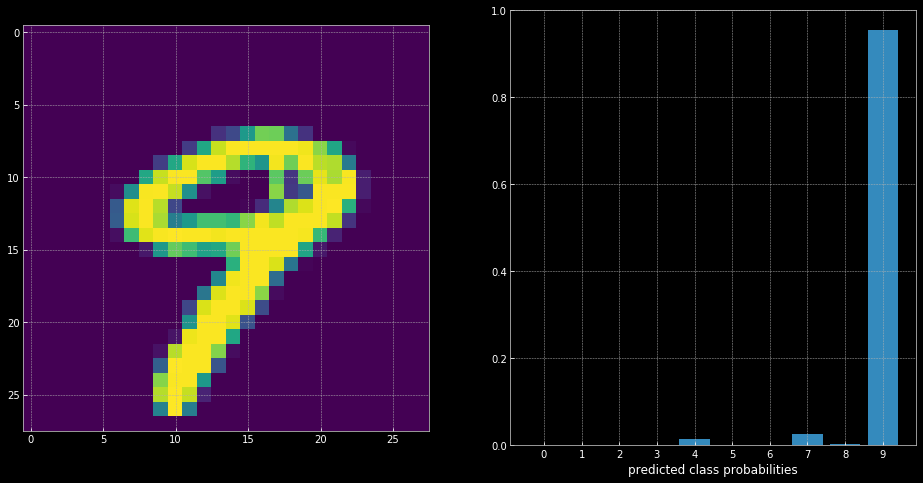

In [15]:
# show an image and the predicted probabilities                                                                                                               
def display(i):
    plt.figure(i + 1)
    image, _ = test_loader.dataset.__getitem__(i)
    image = image.to(device) # convert to CUDA tensors
    logprob = model(image).cpu() #get tensors back to CPU for plotting
    prob = torch.exp(logprob).squeeze().data
    plt.subplot(121)
    plt.imshow(image.squeeze().numpy())
    plt.subplot(122)
    plt.bar(range(10), prob.numpy())
    plt.xlabel('predicted class probabilities')
    plt.xticks(range(10))
    plt.ylim([0, 1])

for i in range(10):
    display(i)

# What happens if we use less hidden units?

In [16]:
# Training settings 
input_size  = 28*28   # images are 28x28 pixels
n_hidden    = 2     # number of hidden units
output_size = 10      # there are 10 classes

model = Network1Layer(input_size, n_hidden, output_size)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [17]:
for epoch in range(1, 3):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.376005
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.319406
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.129168
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.977037
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.000890
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.980895
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.774043
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.792106
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.722591
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.649528

Test set: Average loss: 1.6524, Accuracy: 3287/10000 (33%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.686417
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.559489
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.662324
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.396380
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.519391
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.718710
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.611650
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.475375
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.533195
T

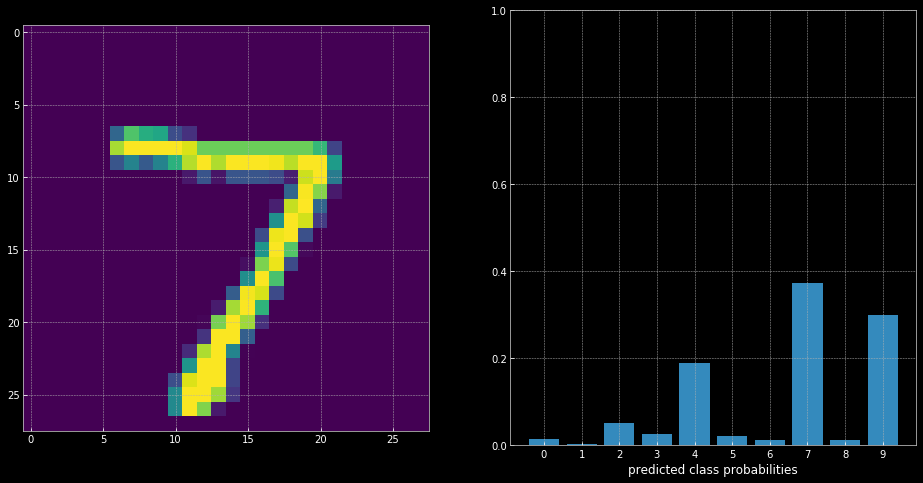

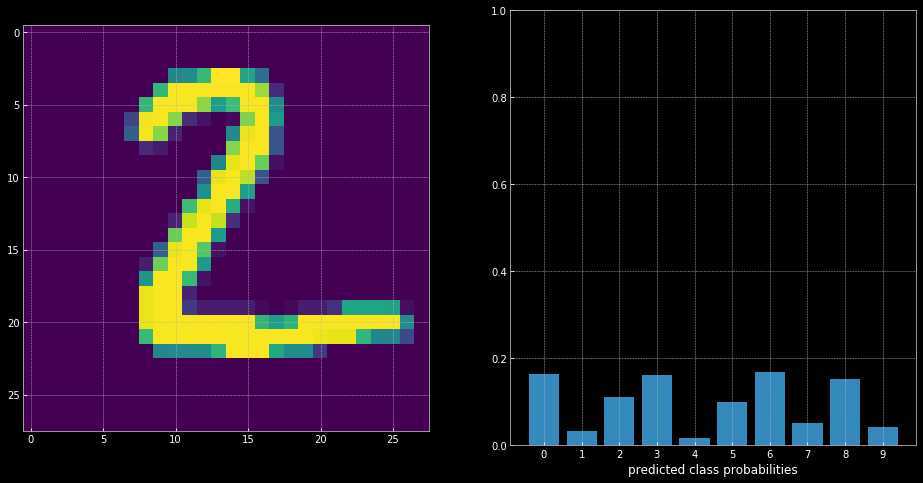

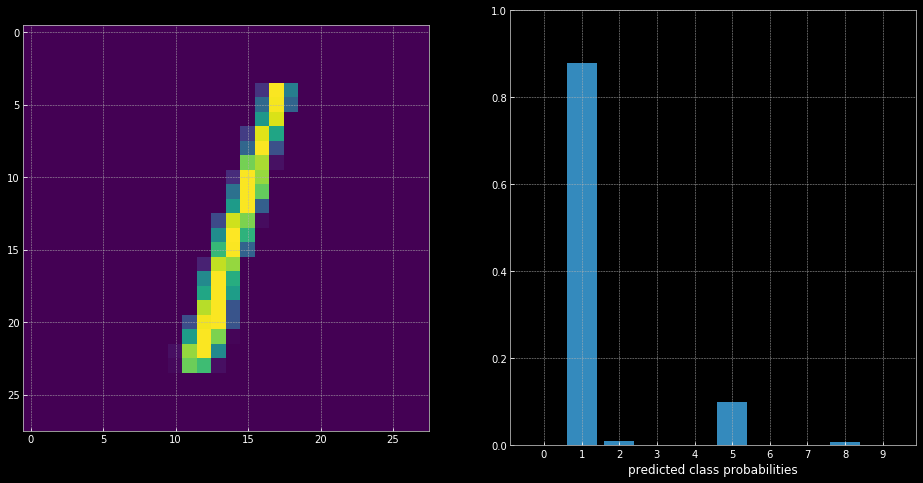

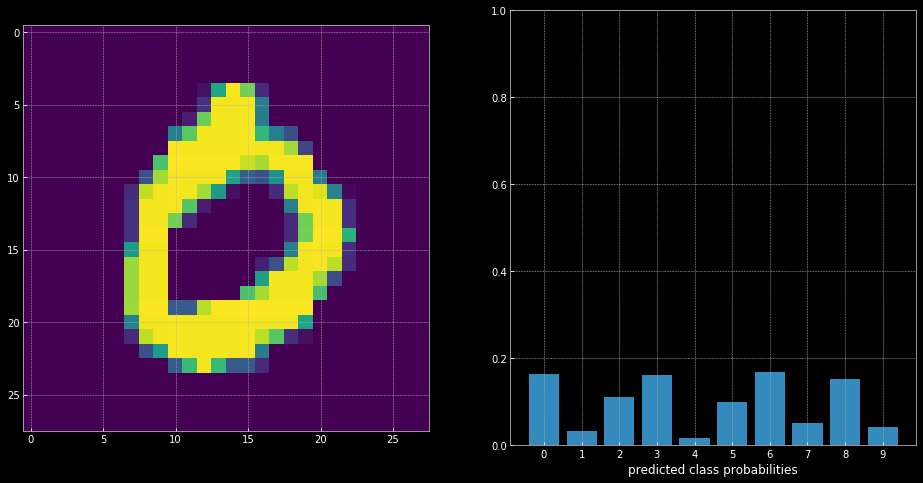

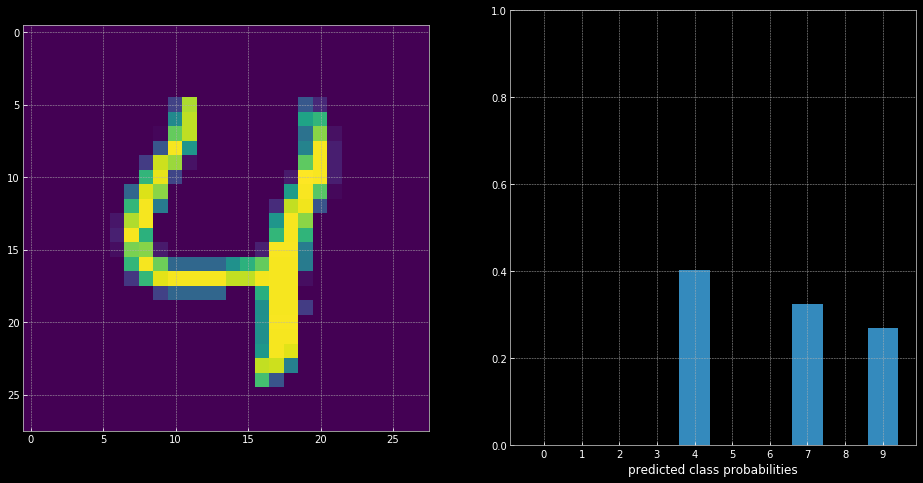

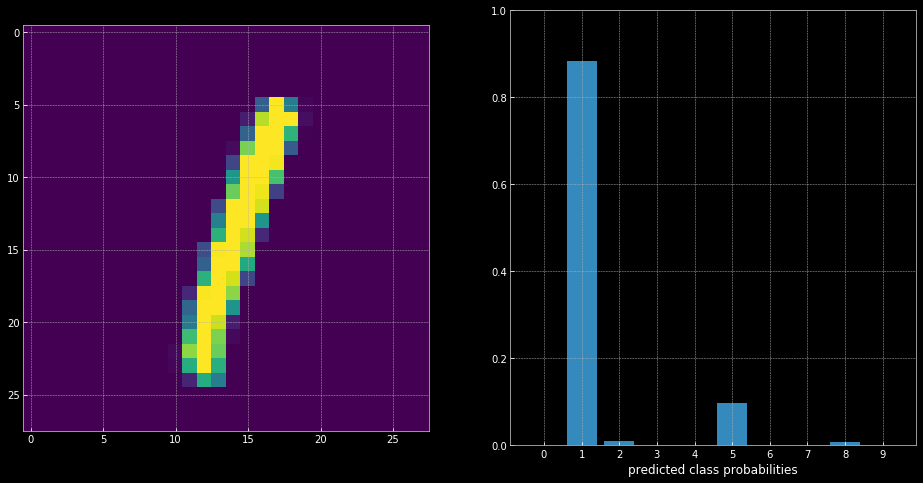

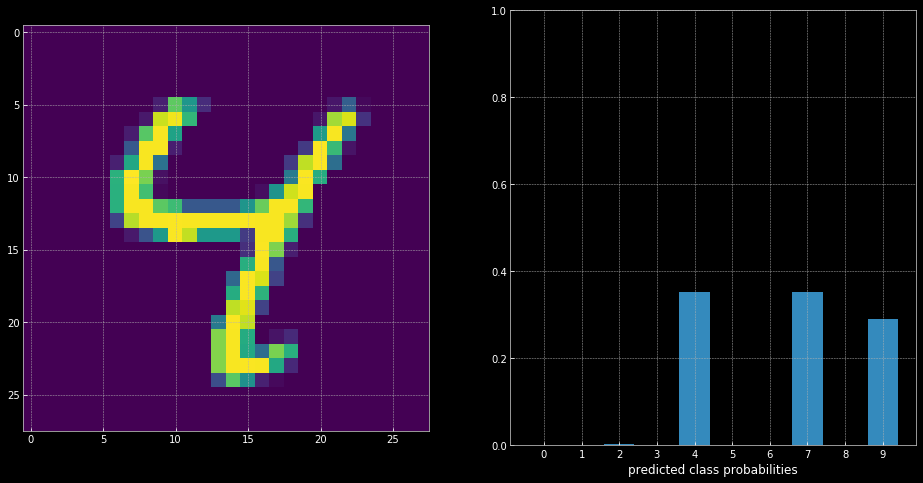

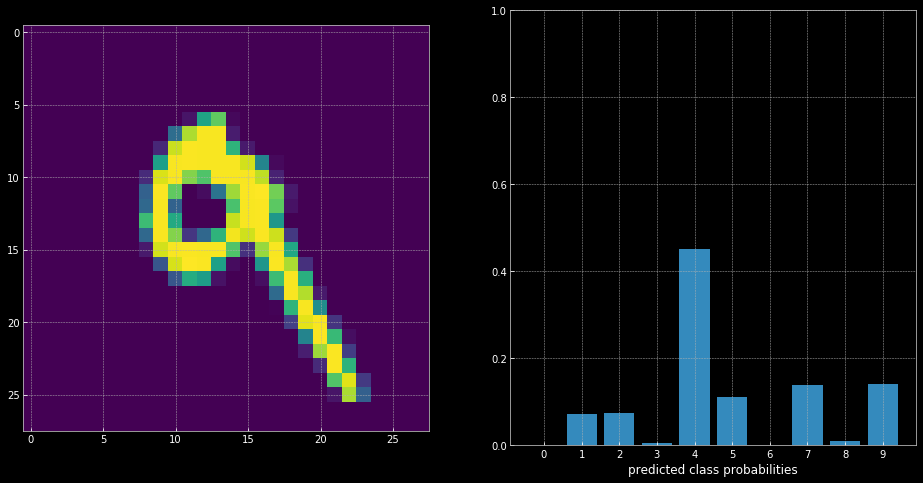

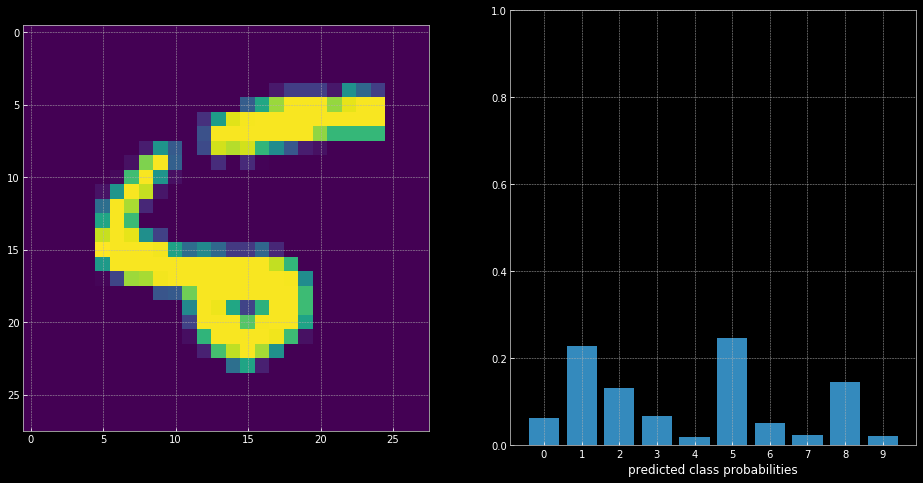

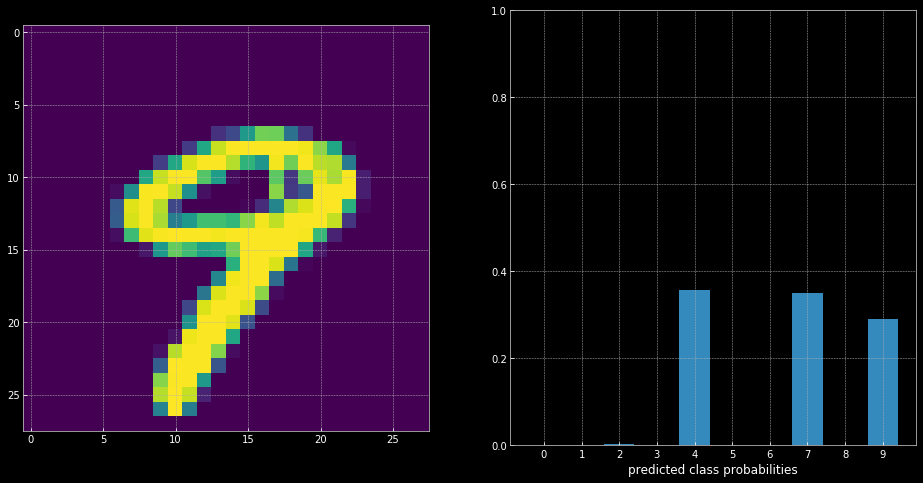

In [18]:
for i in range(10):
    display(i)

# Things to try out

* Try different numbers of layers and hidden units
* Try different non-linearities (tanh, sigmoid)
* Try on other datasets (CIFAR 10)